Install Necessary Libraries

In [3]:
!pip install --upgrade scikit-learn
!pip install --upgrade catboost
!pip install dask[dataframe]
!pip install xgboost lightgbm

Import data handling, ML models, hyperparameter tuning, and metrics libraries.

In [4]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

Load and Split the Dataset

In [5]:
# Load the dataset
cancer = datasets.load_breast_cancer()
X, y = cancer.data, cancer.target

# Split dataset into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Applying feature scaling to fix Logistic Regression issue
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Defining Models and Hyperparameters. 7 ML models: SVM, Random Forest, Logistic Regression, XGBoost, LightGBM, CatBoost, and Neural Networks (MLP). Using 5-fold cross-validation (StratifiedKFold) to ensure robust evaluation.

In [6]:
# Define k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models and hyperparameters for tuning
models = {
    "SVM": {
        "model": SVC(),
        "params": {
            "kernel": ["linear", "rbf"],
            "C": [0.1, 1, 10, 100],
            "gamma": ["scale", "auto", 0.001, 0.01, 0.1]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [50, 100, 200, 300],
            "max_depth": [None, 10, 20, 30],
            "criterion": ["gini", "entropy"]
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=10000),
        "params": {
            "C": [0.1, 1, 10, 100],
            "solver": ["liblinear", "lbfgs", "newton-cg"]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7]
        }
    },
    "LightGBM": {
        "model": LGBMClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "num_leaves": [20, 31, 40]
        }
    },
    "CatBoost": {
        "model": CatBoostClassifier(verbose=0),
        "params": {
            "iterations": [100, 200, 300],
            "learning_rate": [0.01, 0.1, 0.2],
            "depth": [4, 6, 8]
        }
    },
    "Neural Network (MLP)": {
        "model": MLPClassifier(max_iter=1000),
        "params": {
            "hidden_layer_sizes": [(50,), (100,), (50, 50)],
            "activation": ["relu", "tanh"],
            "alpha": [0.0001, 0.001, 0.01],
            "learning_rate": ["constant", "adaptive"]
        }
    }
}

Performing Randomized Search for Hyperparameter Tuning. Training each model with 10 random hyperparameter configurations. Storing the best model & validation accuracy for each algorithm.

In [7]:
# Performing RandomizedSearchCV for each model
best_models = {}
for model_name, model_info in models.items():
    random_search = RandomizedSearchCV(model_info["model"], model_info["params"],
                                       n_iter=10, cv=kfold, scoring='accuracy',
                                       n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)

    # Storing the best model and its accuracy
    best_models[model_name] = {
        "best_estimator": random_search.best_estimator_,
        "best_score": random_search.best_score_
    }

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:43:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 285, number of negative: 170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4545
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626374 -> initscore=0.516691
[LightGBM] [Info] Start training from score 0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

Evaluating Models on the Test Dataset. Evaluating test accuracy on unseen data.
Storing results in a DataFrame for comparison.

In [8]:
# Evaluate the best models on the test dataset
test_results = []
for model_name, model_data in best_models.items():
    best_model = model_data["best_estimator"]
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    test_results.append({"Model": model_name, "Best Validation Accuracy": model_data["best_score"], "Test Accuracy": accuracy})

# Convert results to DataFrame and display
results_df = pd.DataFrame(test_results)
print(results_df)

                  Model  Best Validation Accuracy  Test Accuracy
0                   SVM                  0.975824       0.982456
1         Random Forest                  0.962637       0.956140
2   Logistic Regression                  0.982418       0.973684
3               XGBoost                  0.971429       0.956140
4              LightGBM                  0.969231       0.956140
5              CatBoost                  0.973626       0.956140
6  Neural Network (MLP)                  0.980220       0.964912


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Printing the Best Model & Classification Report. Identifing the best model based on validation accuracy. Evaluating its performance using a classification report.

In [9]:
# Printing classification report for the best model
best_model_name = max(best_models, key=lambda x: best_models[x]["best_score"])
best_model = best_models[best_model_name]["best_estimator"]
y_pred = best_model.predict(X_test)

print(f"\nBest Model: {best_model_name}")
print(classification_report(y_test, y_pred))


Best Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        42
           1       0.97      0.99      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



Validation vs Test Accuracy (Bar Chart)

<Figure size 1200x600 with 0 Axes>

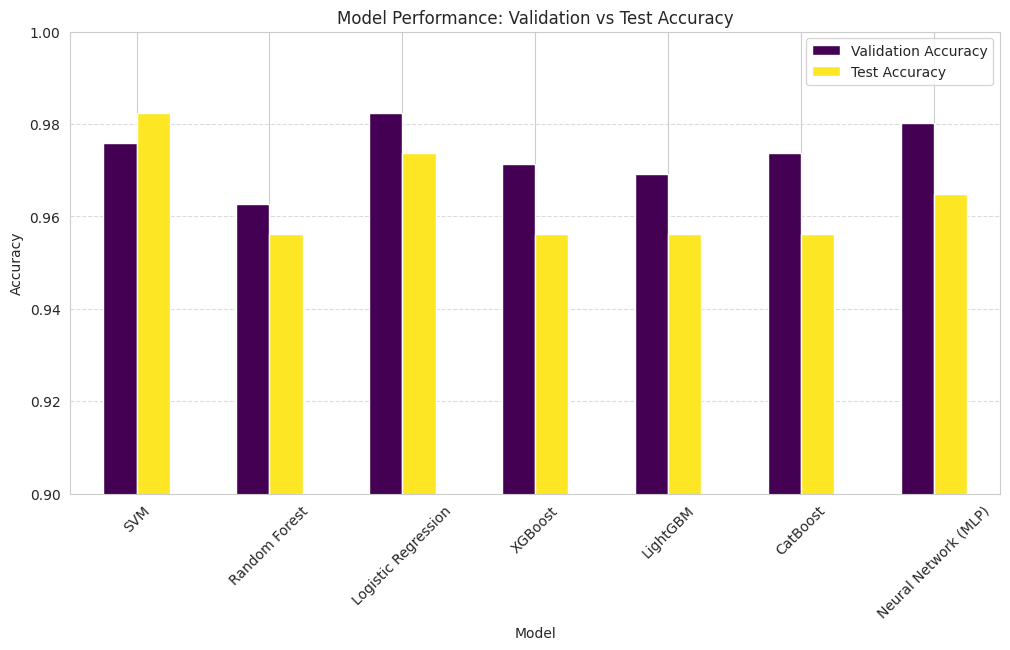

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure size and style
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Bar chart for validation vs test accuracy of all models
fig, ax = plt.subplots(figsize=(12, 6))
results_df.plot(kind='bar', x='Model', y=['Best Validation Accuracy', 'Test Accuracy'], ax=ax, colormap="viridis")

plt.title("Model Performance: Validation vs Test Accuracy")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0.9, 1)  # Set y-axis range for better visualization
plt.legend(["Validation Accuracy", "Test Accuracy"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Model Performance (Scatter Plot)

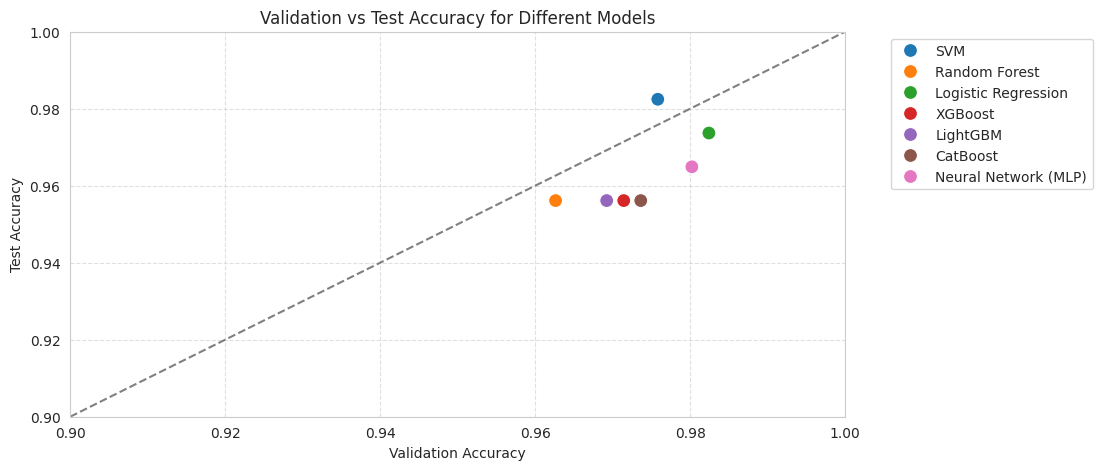

In [11]:
plt.figure(figsize=(10, 5))

# Scatter plot for Validation vs Test Accuracy
sns.scatterplot(x=results_df["Best Validation Accuracy"], y=results_df["Test Accuracy"], hue=results_df["Model"], s=100, palette="tab10")

plt.title("Validation vs Test Accuracy for Different Models")
plt.xlabel("Validation Accuracy")
plt.ylabel("Test Accuracy")
plt.xlim(0.9, 1)
plt.ylim(0.9, 1)
plt.axline((0.9, 0.9), slope=1, linestyle="--", color="gray")  # Reference line for comparison
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Accuracy Distribution (Box Plot)

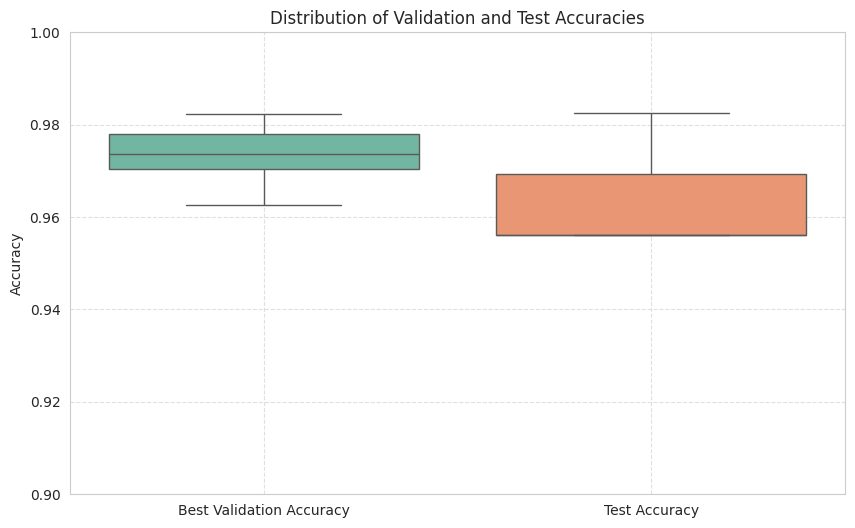

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df.iloc[:, 1:], palette="Set2")

plt.title("Distribution of Validation and Test Accuracies")
plt.ylabel("Accuracy")
plt.ylim(0.9, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Model Accuracy Trends (Line Plot)

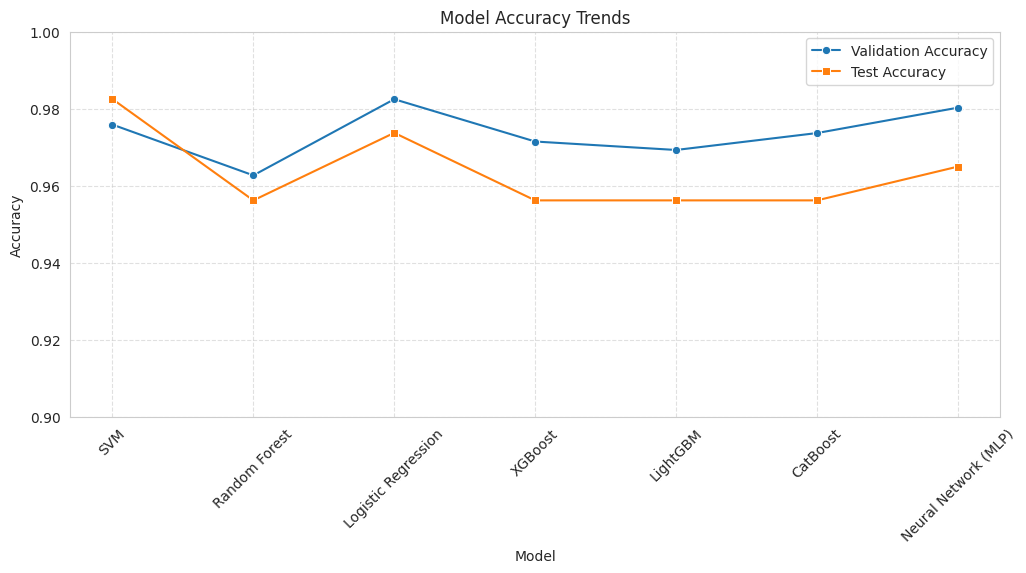

In [13]:
plt.figure(figsize=(12, 5))

# Line plot for Model Accuracy Trends
sns.lineplot(x=results_df["Model"], y=results_df["Best Validation Accuracy"], marker="o", label="Validation Accuracy")
sns.lineplot(x=results_df["Model"], y=results_df["Test Accuracy"], marker="s", label="Test Accuracy")

plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.ylim(0.9, 1)
plt.title("Model Accuracy Trends")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()